# ESS electives report

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap

# Load the dataframe using the correct file name
file_path = 'data/ESS_electives_op_DEC2025.csv'
df = pd.read_csv(file_path)
print(f"Data Loaded. Shape: {df.shape}")

# Define output directory
OUTPUT_DIR = 'output'
    # Create the folder if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory set to: {os.path.abspath(OUTPUT_DIR)}")

# In Qualtrics exports:
# Row 0 = Column Headers (Q1, Q2...) -> df.columns
# Row 1 = Question Text ("How difficult was...") -> df.iloc[0]
# Row 2 = Import IDs -> df.iloc[1]
# Row 3+ = Actual Data -> df.iloc[2:]

questions_row = df.iloc[0]
print("Header and Question Text rows identified.")

Data Loaded. Shape: (100, 187)
Output directory set to: /Users/stefanograziosi/Documents/GitHub/ESS_electives_report/output
Header and Question Text rows identified.


## Column Mapping

In [2]:
def extract_course_info(question_text):
    """
    Parses question text to extract Course Name and Category.
    """
    if not isinstance(question_text, str):
        return None, None
    
    course_name = None
    category = None
    
    # Pattern 1: "... questions below about <Course>? - <Question>"
    match_about = re.search(r"about\s+(.*?)\?\s+-(.*)", question_text)
    
    # Pattern 2: "Would you enrol in <Course> again?"
    match_enrol = re.search(r"Would you enrol in\s+(.*?)(?: again)?\??$", question_text, re.IGNORECASE)
    
    # Pattern 3: "When did you sit the exam for <Course>?"
    match_session = re.search(r"sit the exam for\s+(.*?)\??$", question_text, re.IGNORECASE)

    if match_about:
        course_name = match_about.group(1).strip()
        sub_text = match_about.group(2).strip()
        
        if "difficult was the course" in sub_text or "hard was the course" in sub_text:
            category = "Course Difficulty"
        elif "difficult was the exam" in sub_text or "hard was the exam" in sub_text:
            category = "Exam Difficulty"
        elif "in line with what has been explained" in sub_text:
            category = "Exam Alignment"
            
    elif match_enrol:
        course_name = match_enrol.group(1).strip()
        category = "Enrol Again"
        
    elif match_session:
        course_name = match_session.group(1).strip()
        category = "Exam Session"

    return course_name, category

# Build the map
course_map = {}
for col in df.columns:
    # Skip metadata columns
    if col in ['StartDate', 'EndDate', 'ResponseId', 'Q1']: continue
        
    q_text = questions_row[col]
    course, cat = extract_course_info(q_text)
    
    if course and cat:
        if course not in course_map:
            course_map[course] = {}
        course_map[course][cat] = col

print(f"Successfully mapped {len(course_map)} courses.")

Successfully mapped 31 courses.


## Data Transformation

In [3]:
# Mappings for converting text to numbers
diff_map = {
    'Easy': 1,
    'Somewhat easy': 2,
    'Neither easy nor difficult': 3,
    'Somewhat difficult': 4,
    'Difficult': 5,
    # Handle numeric strings if they appear
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5
}

agree_map = {
    'Strongly disagree': 5,
    'Somewhat disagree': 4,
    'Neither agree nor disagree': 3,
    'Somewhat agree': 2,
    'Strongly agree': 1
}

records = []
# Start reading data from index 2 (skipping Question Text and Import ID rows)
data_rows = df.iloc[2:]

for idx, row in data_rows.iterrows():
    respondent_id = row['ResponseId']
    
    for course, cols in course_map.items():
        # Check if the student took this course (Difficulty column is not empty)
        c_diff_col = cols.get('Course Difficulty')
        
        if c_diff_col and pd.notna(row[c_diff_col]):
            # Get raw text values
            raw_c_diff = row.get(cols.get('Course Difficulty'))
            raw_e_diff = row.get(cols.get('Exam Difficulty'))
            raw_align  = row.get(cols.get('Exam Alignment'))
            raw_enrol  = row.get(cols.get('Enrol Again'))
            
            rec = {
                'RespondentId': respondent_id,
                'Course': course,
                'Course Difficulty': diff_map.get(raw_c_diff),
                'Exam Difficulty': diff_map.get(raw_e_diff),
                'Exam Alignment': agree_map.get(raw_align),
                'Enrol Again Text': raw_enrol
            }
            
            # Convert Enrolment to 0/1
            if isinstance(raw_enrol, str) and 'Yes' in raw_enrol:
                rec['Enrol Again'] = 1
            else:
                rec['Enrol Again'] = 0
                
            records.append(rec)

long_df = pd.DataFrame(records)
print(f"Processed {len(long_df)} feedback records.")
long_df.head()

Processed 350 feedback records.


,RespondentId,Course,Course Difficulty,Exam Difficulty,Exam Alignment,Enrol Again Text,Enrol Again
0,R_2Uby8w29FHmnnoN,Advanced Microeconomics,5,4.0,NaN,"No, but I would enrol in the second year",0
1,R_2pYgmWKvuuhnxrP,Advanced Microeconomics,4,3.0,NaN,"Yes, I would enrol again",1
2,R_8hR1FMyoeDEWzA7,Advanced Microeconomics,5,5.0,5.0,"No, I would not enrol in the course at all",0
3,R_8hR1FMyoeDEWzA7,Development Economics,3,3.0,1.0,"Yes, I would enrol again",1
4,R_8hR1FMyoeDEWzA7,Labour Economics,4,4.0,4.0,"No, I would not enrol in the course at all",0


## Analysis and visualisation

In [4]:
# 1. Aggregate Data
summary = long_df.groupby('Course').agg(
    Responses=('RespondentId', 'count'),
    Avg_Course_Difficulty=('Course Difficulty', 'mean'),
    Avg_Exam_Difficulty=('Exam Difficulty', 'mean'),
    Avg_Exam_Alignment=('Exam Alignment', 'mean'),
    Enrol_Again_Rate=('Enrol Again', 'mean')
).reset_index()

# Filter for courses with enough data (e.g., >2 responses) to make charts meaningful
summary_filtered = summary[summary['Responses'] >= 3].sort_values('Responses', ascending=False)

# 2. Save Raw Data
csv_path = os.path.join(OUTPUT_DIR, 'summary_table.csv')
summary.to_csv(csv_path, index=False)
print(f"Saved full summary to: {csv_path}")

# 3. Create a Styled Table for Display
# Scale: 1 (Green/Easy/Good) to 5 (Red/Hard/Bad)
def style_table(df):
    return df.style.background_gradient(
        cmap='RdYlGn_r', # Red-Yellow-Green Reversed (Low=Green, High=Red)
        subset=['Avg_Course_Difficulty', 'Avg_Exam_Difficulty', 'Avg_Exam_Alignment'],
        vmin=1, vmax=5
    ).background_gradient(
        cmap='RdYlGn', # Normal Green-Red (High=Green)
        subset=['Enrol_Again_Rate'],
        vmin=0, vmax=1
    ).format({
        'Avg_Course_Difficulty': '{:.2f}',
        'Avg_Exam_Difficulty': '{:.2f}',
        'Avg_Exam_Alignment': '{:.2f}',
        'Enrol_Again_Rate': '{:.0%}'
    }).set_caption("Course Feedback Summary (Green = Easy/Aligned/High Enrolment)")

# Display
style_table(summary_filtered.head(len(course_map))) # Show top all courses

Saved full summary to: output/summary_table.csv


,Course,Responses,Avg_Course_Difficulty,Avg_Exam_Difficulty,Avg_Exam_Alignment,Enrol_Again_Rate
21,Microeconometrics,57,3.77,4.04,2.61,96%
11,Foundation of Social Sciences - Module II A,45,2.16,2.23,2.18,78%
12,Foundation of Social Sciences - Module II B,32,2.28,2.68,2.03,91%
28,Time Series Analysis of Economic and Financial Data,23,3.30,3.36,2.04,78%
5,Development Economics,20,2.20,3.20,2.70,65%
1,Advanced Microeconomics,20,4.65,4.53,3.00,45%
19,Labour Economics,15,3.53,4.07,2.40,67%
8,Economics of European Integration,15,2.53,2.80,1.73,100%
17,International Macroeconomics and Finance,13,3.85,4.25,2.75,62%
14,"Globalization, Divergence, and Inequality in Historical Perspective",9,2.22,2.56,1.25,78%


### Plot 1: Difficulty Comparison

Saved plot to: output/fig_course_vs_exam_difficulty_barh.pdf


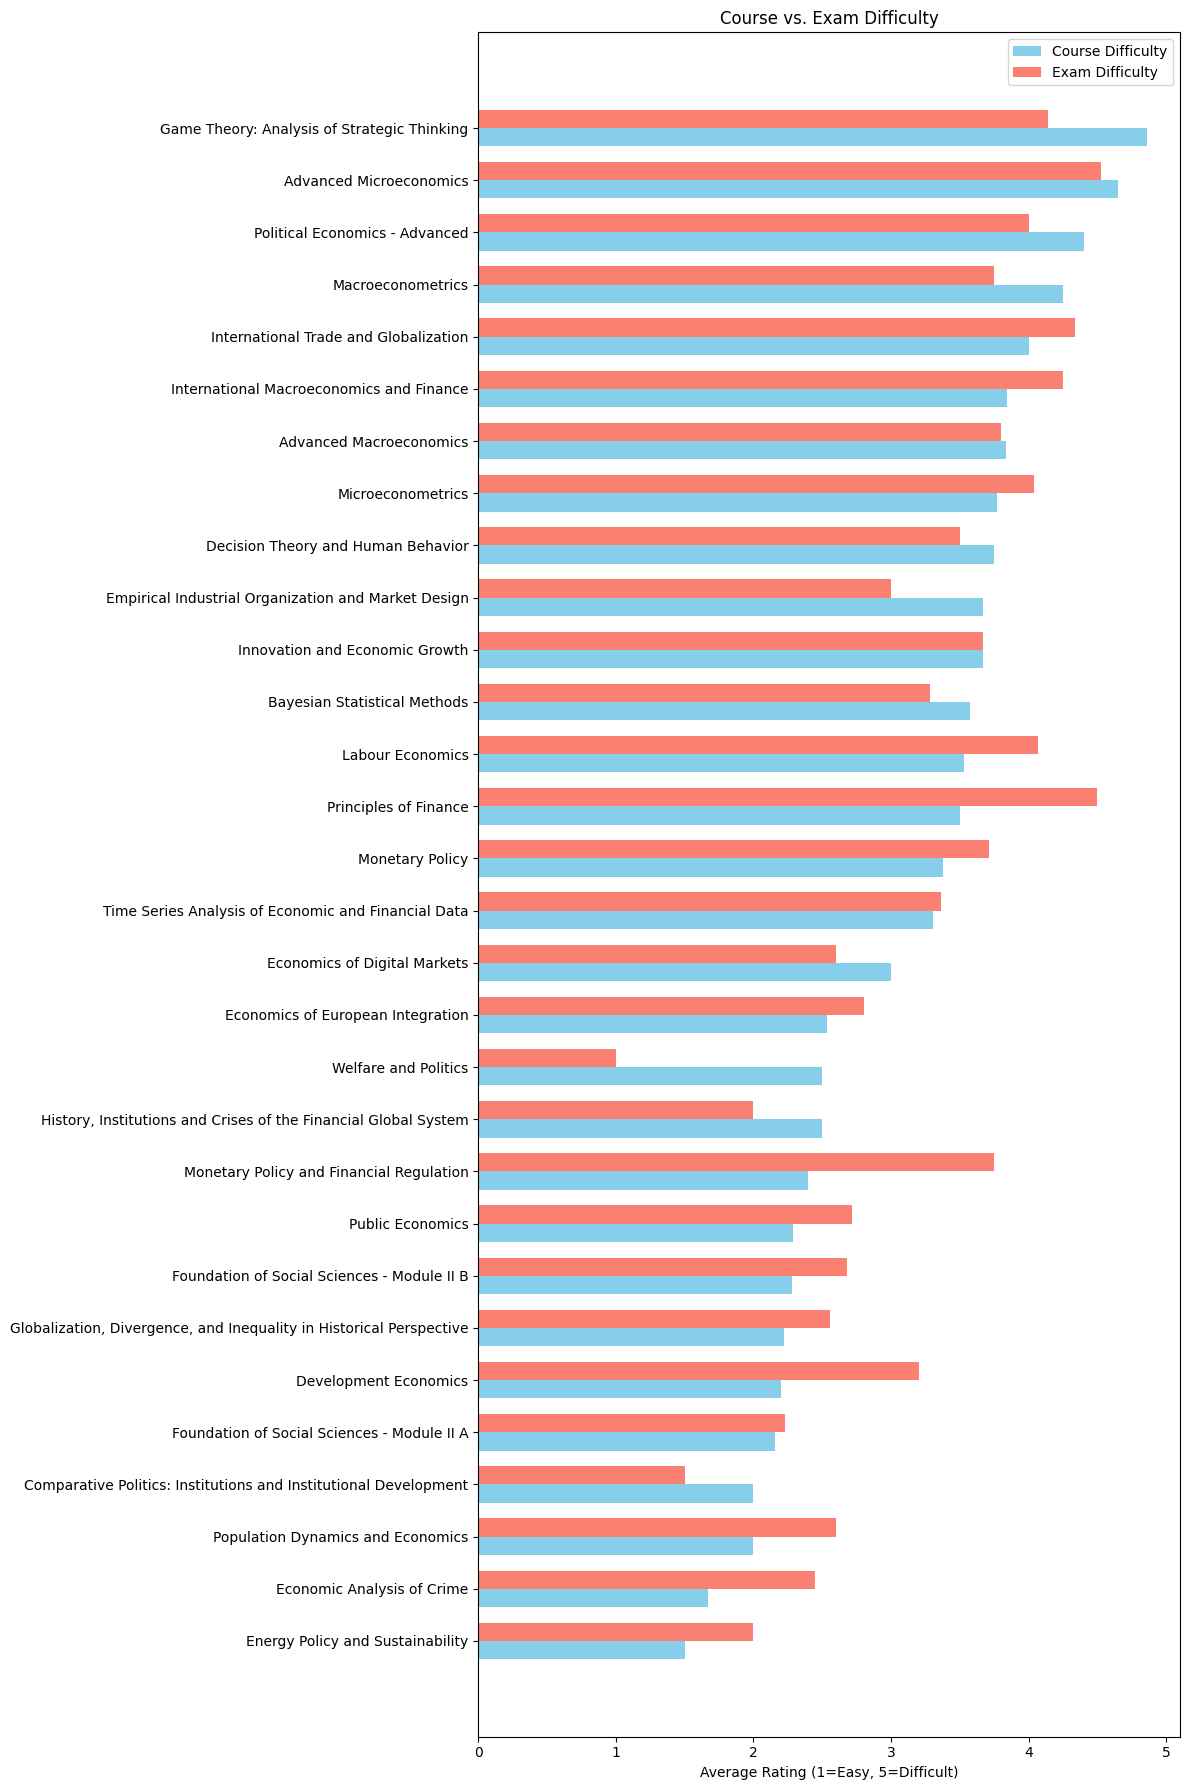

In [5]:
plt.figure(figsize=(12, len(summary)*0.6))
plot_data = summary.sort_values('Avg_Course_Difficulty', ascending=True)

y_pos = np.arange(len(plot_data))
height = 0.35

plt.barh(y_pos - height/2, plot_data['Avg_Course_Difficulty'], height, label='Course Difficulty', color='skyblue')
plt.barh(y_pos + height/2, plot_data['Avg_Exam_Difficulty'], height, label='Exam Difficulty', color='salmon')

plt.yticks(y_pos, plot_data['Course'])
plt.xlabel('Average Rating (1=Easy, 5=Difficult)')
plt.title('Course vs. Exam Difficulty')
plt.legend()
plt.tight_layout()

# Save (PDF)
plot_path = os.path.join(OUTPUT_DIR, 'fig_course_vs_exam_difficulty_barh.pdf')
plt.savefig(plot_path, format='pdf', bbox_inches='tight')
print(f"Saved plot to: {plot_path}")
plt.show()

### Plot 2: Re-enrollment Rates

/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_35760/508470824.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], color='#666666', fontsize=10)


Chart saved to: output/fig_student_enrollment_intentions_stacked_barh.pdf


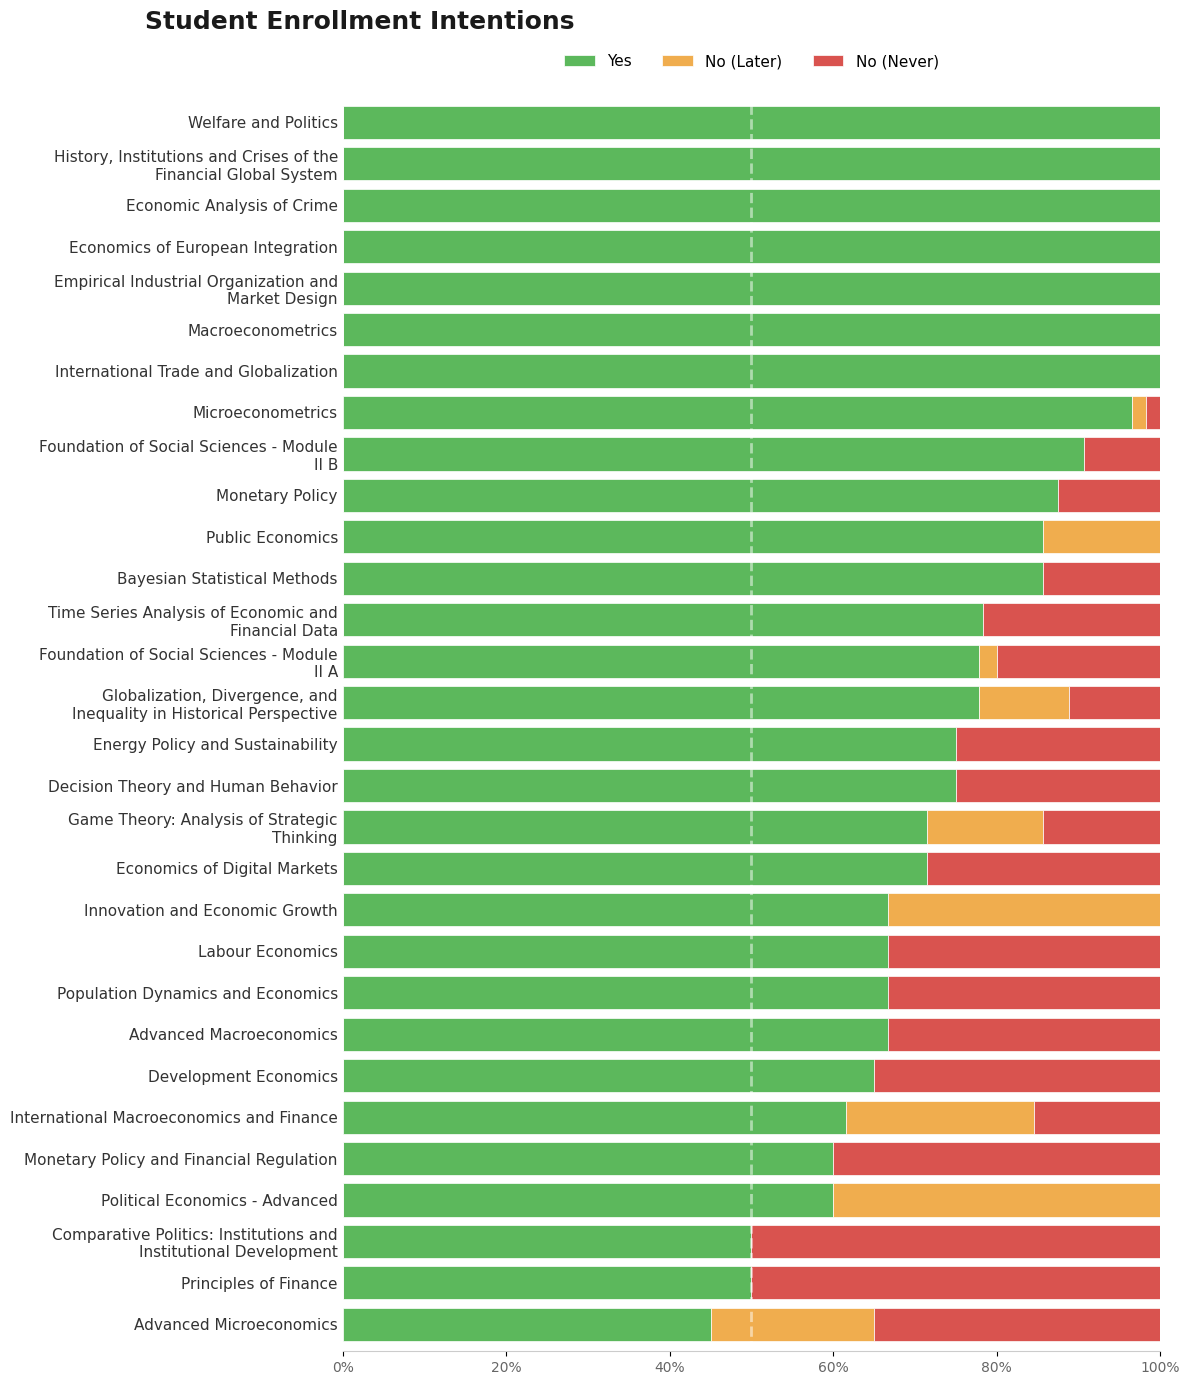

In [6]:
# --- 1. PREPARE DATA ---
enroll_counts = long_df.groupby(['Course', 'Enrol Again Text']).size().unstack(fill_value=0)
enroll_pct = enroll_counts.div(enroll_counts.sum(axis=1), axis=0)

rename_map = {}
for c in enroll_pct.columns:
    if 'Yes' in c:
        rename_map[c] = 'Yes'
    elif 'No, but' in c or 'second year' in c:
        rename_map[c] = 'No (Later)'
    elif 'No' in c:
        rename_map[c] = 'No (Never)'
    else:
        rename_map[c] = c

enroll_pct = enroll_pct.rename(columns=rename_map)

for col in ['Yes', 'No (Later)', 'No (Never)']:
    if col not in enroll_pct.columns:
        enroll_pct[col] = 0.0
enroll_pct = enroll_pct[['Yes', 'No (Later)', 'No (Never)']]

# Sort so best (highest Yes) is near the bottom/top depending on preference
enroll_pct = enroll_pct.sort_values('Yes', ascending=True)

# --- 2. SETUP PLOT ---
num_courses = len(enroll_pct)
fig_height = max(10, num_courses * 0.5)

fig, ax = plt.subplots(figsize=(12, fig_height))
ax.set_facecolor('white')

# --- 3. PLOT ---
colors = ['#5cb85c', '#f0ad4e', '#d9534f']
enroll_pct.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.8,
    edgecolor='white',
    linewidth=0.5
)

# --- 4. FORMATTING ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#cccccc')

ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()],
                   fontsize=11, color='#333333')
ax.tick_params(axis='y', length=0)

ax.set_xlim(0, 1)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], color='#666666', fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('')

ax.axvline(0.5, color='white', linestyle='--', linewidth=2, alpha=0.5)

# --- 5. TITLES & LEGEND ---
plt.suptitle('Student Enrollment Intentions',
             x=0.125, y=0.92, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')

ax.legend(title='', bbox_to_anchor=(0.5, 1.01), loc='lower center',
          ncol=3, frameon=False, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.93])

# Save (PDF)
save_path = os.path.join(OUTPUT_DIR, 'fig_student_enrollment_intentions_stacked_barh.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
print(f"Chart saved to: {save_path}")
plt.show()

### Plot 3: Heatmap of Metrics

Saved plot to: output/fig_course_metrics_heatmap.pdf


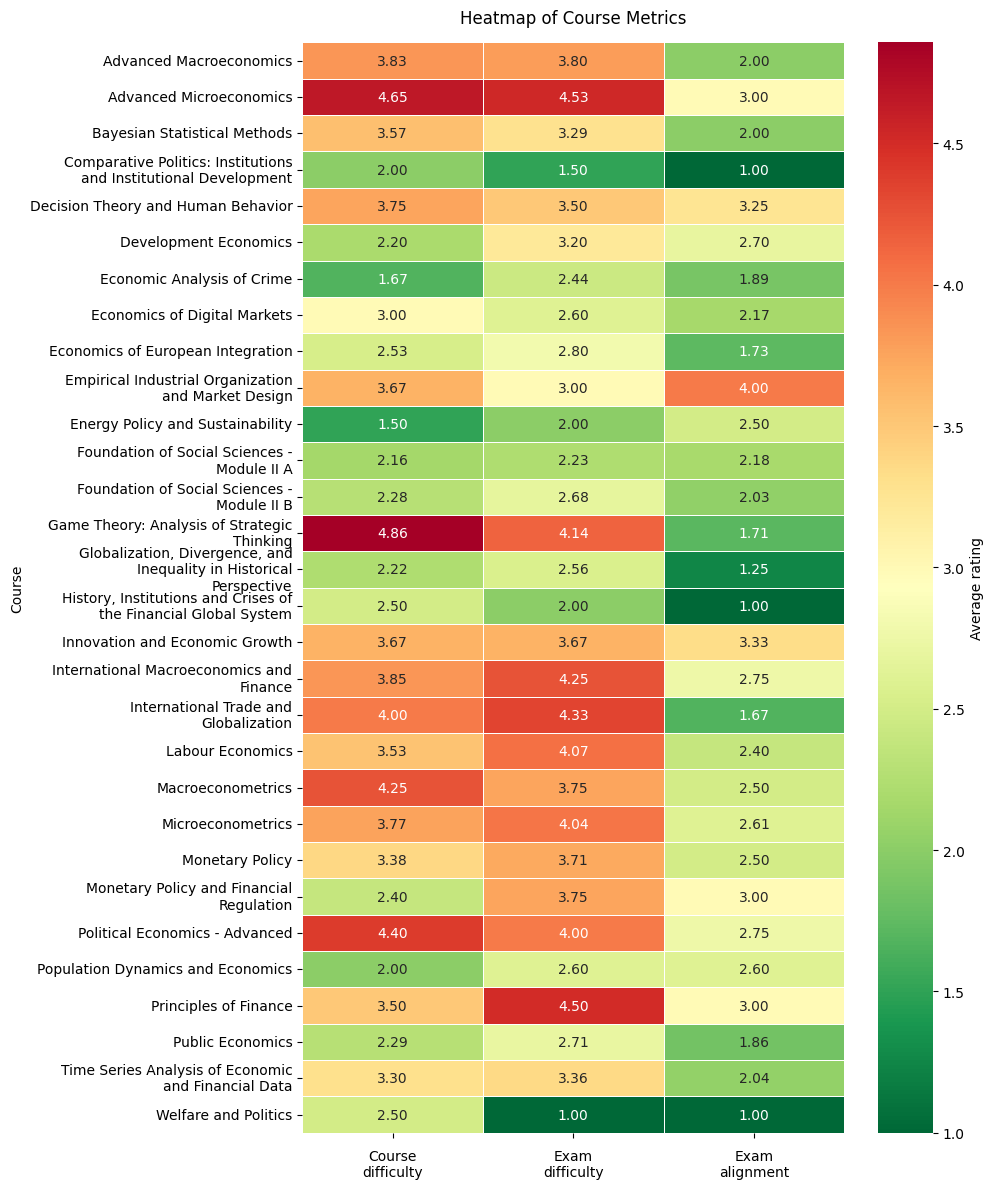

In [7]:
plt.figure(figsize=(10, 12))

# Make labels clean (no long snake_case)
heatmap_data = summary.set_index('Course')[[
    'Avg_Course_Difficulty',
    'Avg_Exam_Difficulty',
    'Avg_Exam_Alignment'
]].rename(columns={
    'Avg_Course_Difficulty': 'Course\ndifficulty',
    'Avg_Exam_Difficulty': 'Exam\ndifficulty',
    'Avg_Exam_Alignment': 'Exam\nalignment'
})

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='RdYlGn_r',
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'label': 'Average rating'}
)

plt.title('Heatmap of Course Metrics', pad=14)

# Improve tick label readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.tick_params(axis='x', pad=8)

# Optional: wrap long course names on Y axis
ax.set_yticklabels([textwrap.fill(t.get_text(), 35) for t in ax.get_yticklabels()], rotation=0)

plt.tight_layout()

# Save (PDF)
plot_path = os.path.join(OUTPUT_DIR, 'fig_course_metrics_heatmap.pdf')
plt.savefig(plot_path, format='pdf', bbox_inches='tight')
print(f"Saved plot to: {plot_path}")
plt.show()

### Plot 4a: Course difficulty distribution

/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_35760/3116729958.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_35760/3116729958.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_35760/3116729958.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])


Violin plot for all courses saved to: output/fig_course_difficulty_distribution_violin_all_courses.pdf


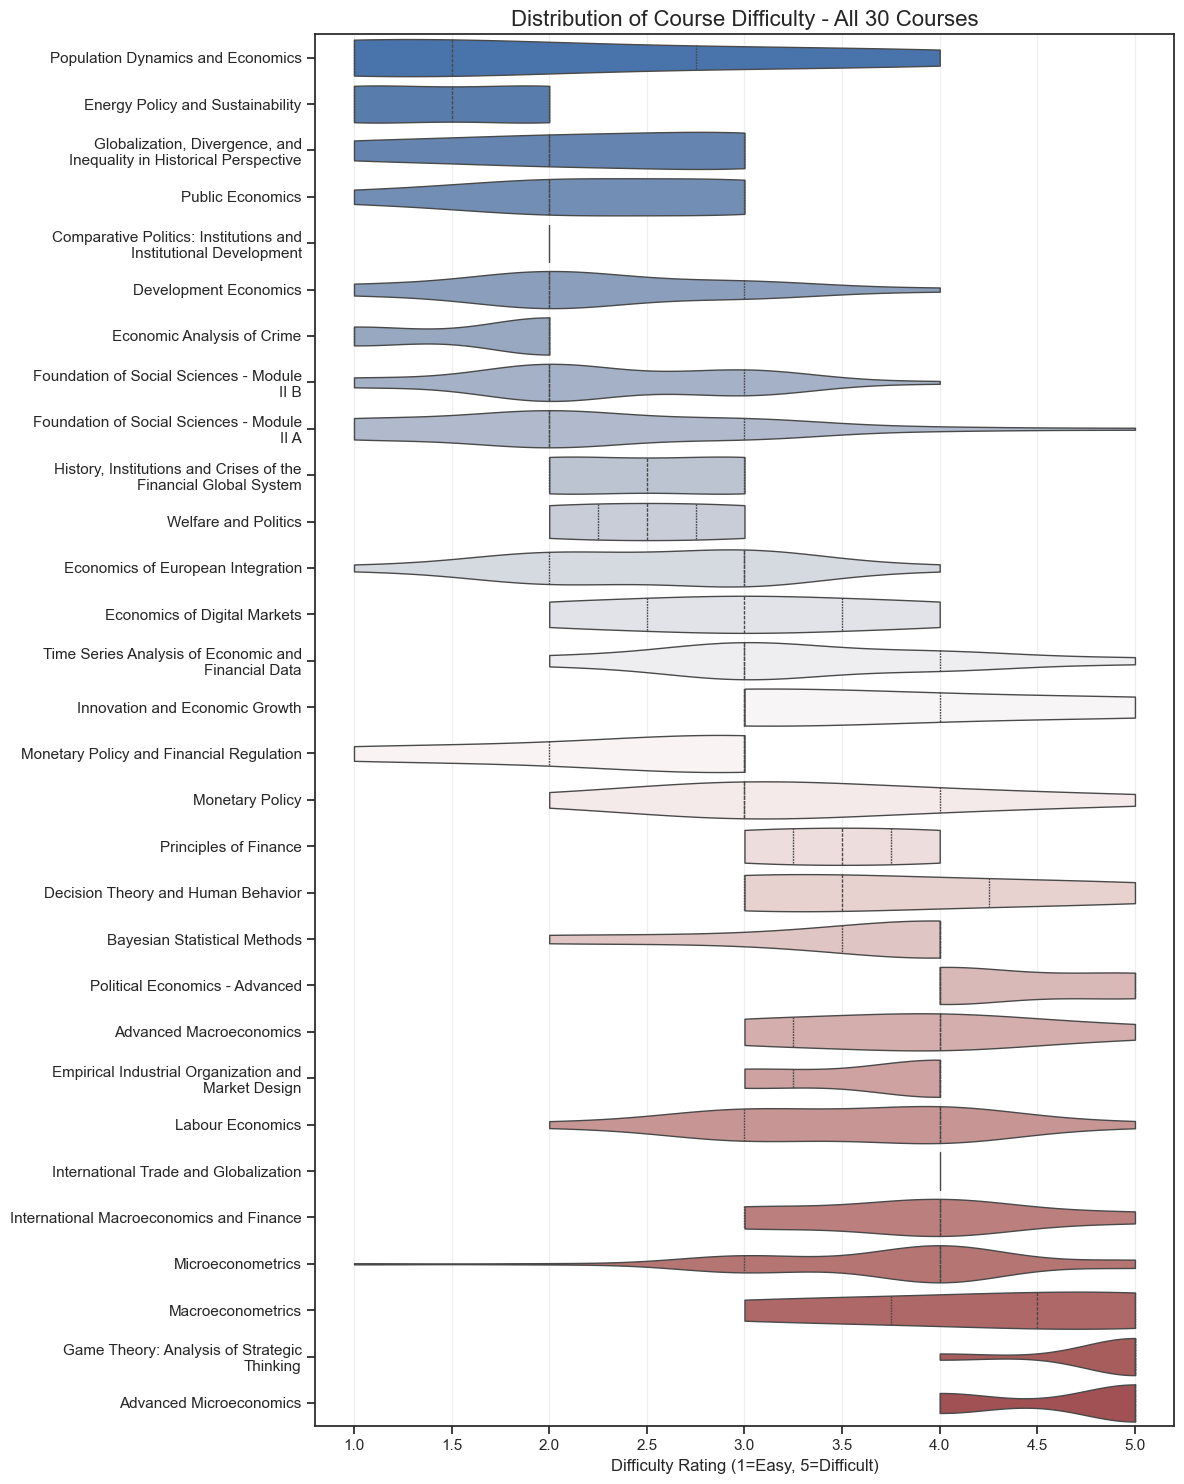

In [8]:
# --- VIOLIN PLOT: ALL COURSES ---
df_all = long_df.copy()

sorted_order = df_all.groupby('Course')['Course Difficulty'].median().sort_values().index

num_courses = len(sorted_order)
dynamic_height = max(10, num_courses * 0.5)

plt.figure(figsize=(12, dynamic_height))
sns.set_theme(style="ticks")

sns.violinplot(
    data=df_all,
    x='Course Difficulty',
    y='Course',
    order=sorted_order,
    palette="vlag",
    linewidth=1,
    cut=0,
    inner="quartile",
    scale='width'
)

plt.title(f'Distribution of Course Difficulty - All {num_courses} Courses', fontsize=16)
plt.xlabel('Difficulty Rating (1=Easy, 5=Difficult)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)

ax = plt.gca()
ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])

plt.tight_layout()

# Save (PDF)
save_path = os.path.join(OUTPUT_DIR, 'fig_course_difficulty_distribution_violin_all_courses.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
print(f"Violin plot for all courses saved to: {save_path}")
plt.show()

### Plot 3b: Exam difficulty distribution

/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_35760/3804390995.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_35760/3804390995.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_35760/3804390995.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])


Exam difficulty plot saved to: output/fig_exam_difficulty_distribution_violin_all_courses.pdf


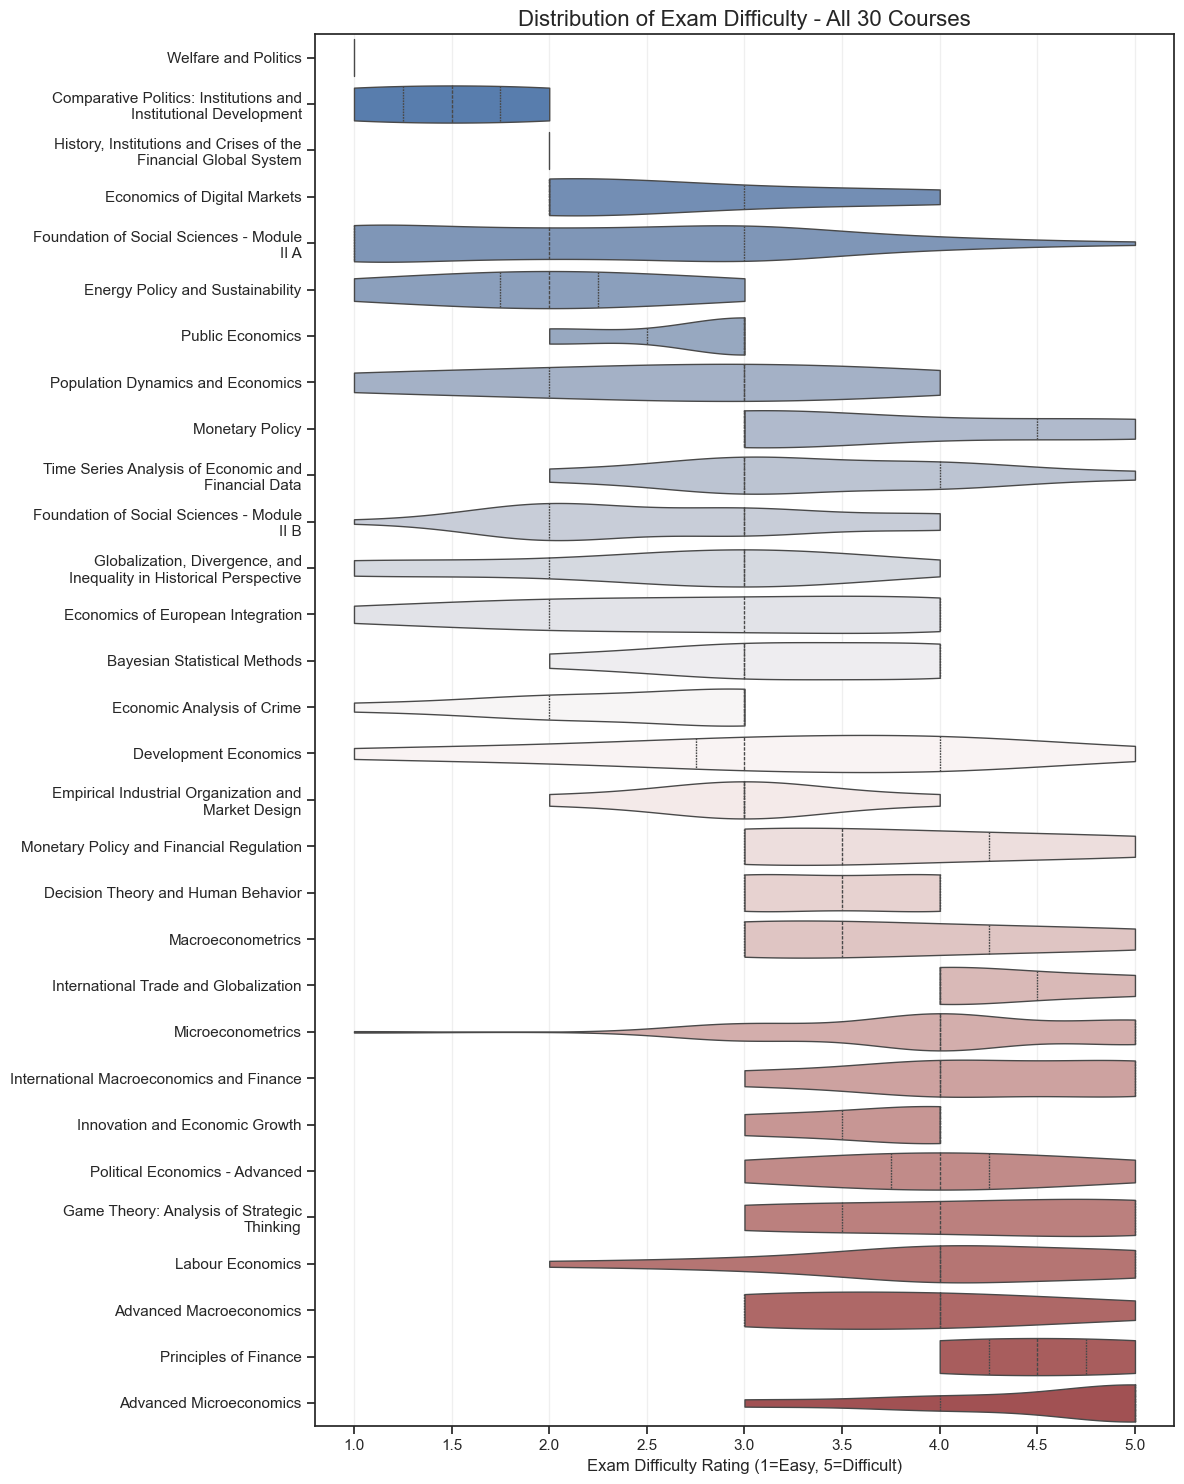

In [9]:
df_exam = long_df.dropna(subset=['Exam Difficulty']).copy()
sorted_order = df_exam.groupby('Course')['Exam Difficulty'].median().sort_values().index

num_courses = len(sorted_order)
dynamic_height = max(10, num_courses * 0.5)

plt.figure(figsize=(12, dynamic_height))
sns.set_theme(style="ticks")

sns.violinplot(
    data=df_exam,
    x='Exam Difficulty',
    y='Course',
    order=sorted_order,
    palette="vlag",
    linewidth=1,
    cut=0,
    inner="quartile",
    scale='width'
)

plt.title(f'Distribution of Exam Difficulty - All {num_courses} Courses', fontsize=16)
plt.xlabel('Exam Difficulty Rating (1=Easy, 5=Difficult)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)

ax = plt.gca()
ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])

plt.tight_layout()

# Save (PDF)
save_path = os.path.join(OUTPUT_DIR, 'fig_exam_difficulty_distribution_violin_all_courses.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
print(f"Exam difficulty plot saved to: {save_path}")
plt.show()

### Plot 4: Setup

In [ ]:
# --- SHARED STYLE FOR BUBBLE CHARTS ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

BUBBLE_CFG = {
    "figsize": (12, 10),
    "facecolor": "white",
    "grid_color": "#e5e5e5",
    "spine_color": "#888888",
    "tick_color": "#666666",
    "label_color": "#333333",
    "neutral_line_color": "#cfcfcf",
    "neutral_line_style": "--",
    "neutral_line_width": 1.5,
    "sizes": (100, 1000),
    "alpha": 0.85,
    "edgecolor": "white",
    "linewidth": 1.5,
    "palette": "RdYlGn",
    "xlim": (0.8, 5.2),
    "ylim": (0.8, 5.4),
    "label_fontsize": 12,
    "label_weight": "bold",
    "tick_labelsize": 11,
    "annotation_fontsize": 9,
    "quadrant_fontsize": 10,
    "quadrant_alpha": 0.6,
    "label_width": 20,
    "dist_threshold": 1.2,
    "min_responses_label": 5,
}

def apply_bubble_style(ax, xlim=None, ylim=None):
    """Apply shared McKinsey-style formatting to the bubble charts."""
    ax.set_facecolor(BUBBLE_CFG["facecolor"])

    # Clean axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(BUBBLE_CFG["spine_color"])
    ax.spines['bottom'].set_color(BUBBLE_CFG["spine_color"])
    ax.tick_params(axis='both', colors=BUBBLE_CFG["tick_color"], labelsize=BUBBLE_CFG["tick_labelsize"])
    ax.grid(True, which='major', color=BUBBLE_CFG["grid_color"], linestyle='-', zorder=0)

    # Limits
    ax.set_xlim(*(xlim if xlim is not None else BUBBLE_CFG["xlim"]))
    ax.set_ylim(*(ylim if ylim is not None else BUBBLE_CFG["ylim"]))

    # Neutral quadrant lines at 3
    ax.axhline(3, color=BUBBLE_CFG["neutral_line_color"], linestyle=BUBBLE_CFG["neutral_line_style"],
               linewidth=BUBBLE_CFG["neutral_line_width"], zorder=1)
    ax.axvline(3, color=BUBBLE_CFG["neutral_line_color"], linestyle=BUBBLE_CFG["neutral_line_style"],
               linewidth=BUBBLE_CFG["neutral_line_width"], zorder=1)

def annotate_interesting_points(ax, df, x_col, y_col, dist_col):
    interesting = df[
        (df['Responses'] >= BUBBLE_CFG["min_responses_label"]) | (df[dist_col] > BUBBLE_CFG["dist_threshold"])
    ].sort_values('Responses', ascending=False)

    for _, row in interesting.iterrows():
        label = wrap_two_lines(
            row['Course'],
            line_width=16,     # chars per line (tune)
            max_total=32       # total chars before ellipsis (tune)
        )

        dx = 8 if row[x_col] < 4 else -8   # offset in points
        dy = 8 if row[y_col] < 4 else -8

        ax.annotate(
            label,
            xy=(row[x_col], row[y_col]),
            xytext=(dx, dy),
            textcoords="offset points",
            ha='left' if dx > 0 else 'right',
            va='bottom' if dy > 0 else 'top',
            fontsize=BUBBLE_CFG["annotation_fontsize"],
            color=BUBBLE_CFG["label_color"],
            weight='medium',
            linespacing=0.9,
            multialignment='center',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
            zorder=3
        )

In [11]:
import textwrap

def wrap_two_lines(text, line_width=16, max_total=32, placeholder="…"):
    text = " ".join(str(text).split())  # normalize spaces
    short = textwrap.shorten(text, width=max_total, placeholder=placeholder)

    # If it fits on one line, keep it one line
    if len(short) <= line_width:
        return short

    words = short.split()
    best = None

    # Try all split points; choose the most "balanced" 2-line split that fits
    for i in range(1, len(words)):
        l1 = " ".join(words[:i])
        l2 = " ".join(words[i:])
        if len(l1) <= line_width and len(l2) <= line_width:
            score = abs(len(l1) - len(l2))
            if best is None or score < best[0]:
                best = (score, l1, l2)

    if best:
        return best[1] + "\n" + best[2]

    # Fallback: wrap and force at most 2 lines (ellipsis on 2nd line)
    wrapped = textwrap.wrap(short, width=line_width, break_long_words=False, break_on_hyphens=False)
    if len(wrapped) <= 2:
        return "\n".join(wrapped)

    line1 = wrapped[0]
    rest = " ".join(wrapped[1:])
    line2 = textwrap.shorten(rest, width=line_width, placeholder=placeholder)
    return line1 + "\n" + line2

### Plot 4a: Course Difficulty vs Exam Alignment

Saved plot to: output/fig_course_difficulty_vs_exam_alignment_bubble.pdf


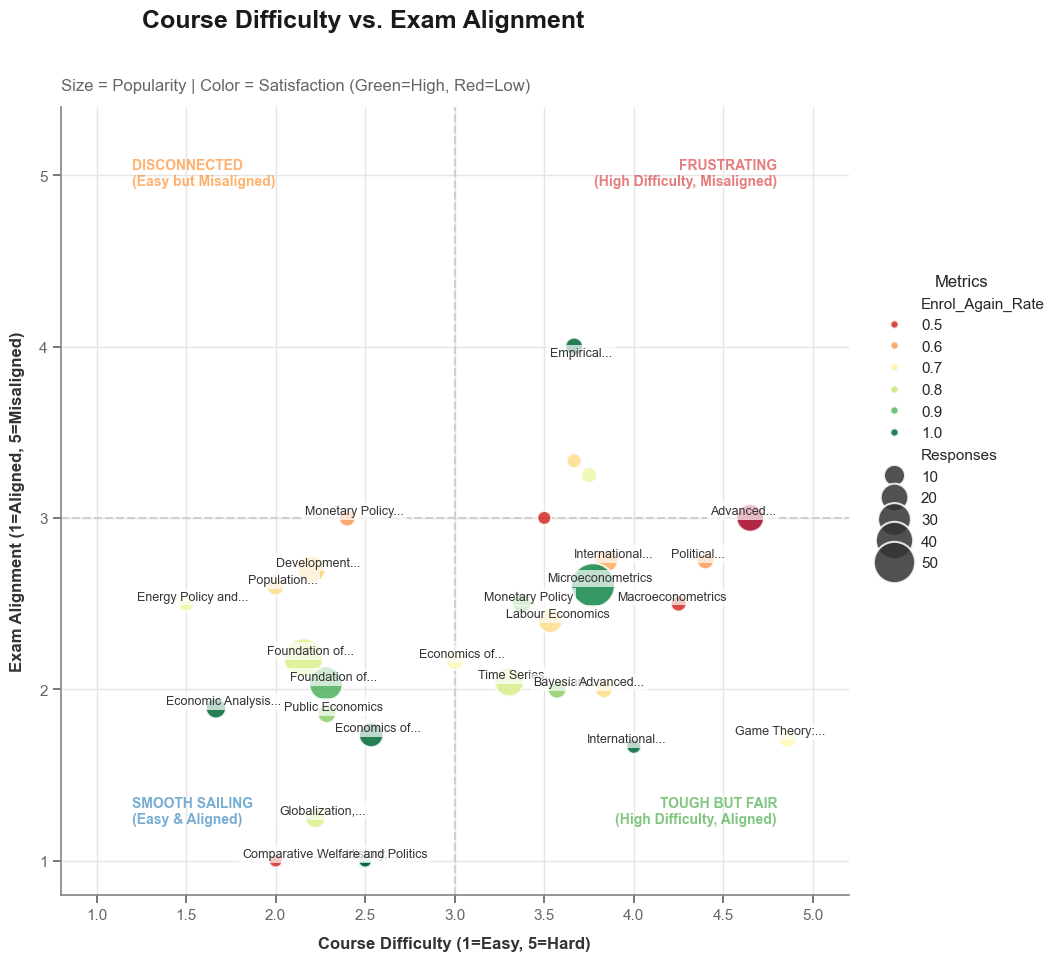

In [12]:
# Distance from neutral (3,3) for labeling
summary['dist_course_diff_vs_exam_align'] = np.sqrt(
    (summary['Avg_Course_Difficulty'] - 3)**2 + (summary['Avg_Exam_Alignment'] - 3)**2
)

fig, ax = plt.subplots(figsize=BUBBLE_CFG["figsize"])
apply_bubble_style(ax, xlim=(0.8, 5.2), ylim=(0.8, 5.4))

sns.scatterplot(
    data=summary,
    x='Avg_Course_Difficulty',
    y='Avg_Exam_Alignment',
    size='Responses',
    hue='Enrol_Again_Rate',
    sizes=BUBBLE_CFG["sizes"],
    palette=BUBBLE_CFG["palette"],
    alpha=BUBBLE_CFG["alpha"],
    edgecolor=BUBBLE_CFG["edgecolor"],
    linewidth=BUBBLE_CFG["linewidth"],
    ax=ax,
    zorder=2
)

ax.set_xlabel('Course Difficulty (1=Easy, 5=Hard)',
              fontsize=BUBBLE_CFG["label_fontsize"], fontweight=BUBBLE_CFG["label_weight"],
              labelpad=10, color=BUBBLE_CFG["label_color"])
ax.set_ylabel('Exam Alignment (1=Aligned, 5=Misaligned)',
              fontsize=BUBBLE_CFG["label_fontsize"], fontweight=BUBBLE_CFG["label_weight"],
              labelpad=10, color=BUBBLE_CFG["label_color"])

annotate_interesting_points(
    ax=ax,
    df=summary,
    x_col='Avg_Course_Difficulty',
    y_col='Avg_Exam_Alignment',
    dist_col='dist_course_diff_vs_exam_align'
)

# Quadrant titles
ax.text(4.8, 5.1, "FRUSTRATING\n(High Difficulty, Misaligned)",
        ha='right', va='top', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#d62728', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(4.8, 1.2, "TOUGH BUT FAIR\n(High Difficulty, Aligned)",
        ha='right', va='bottom', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#2ca02c', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(1.2, 1.2, "SMOOTH SAILING\n(Easy & Aligned)",
        ha='left', va='bottom', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#1f77b4', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(1.2, 5.1, "DISCONNECTED\n(Easy but Misaligned)",
        ha='left', va='top', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#ff7f0e', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])

fig.suptitle('Course Difficulty vs. Exam Alignment',
             x=0.125, y=0.96, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')
ax.set_title('Size = Popularity | Color = Satisfaction (Green=High, Red=Low)',
             loc='left', fontsize=12, color='#666666', pad=12)

ax.legend(bbox_to_anchor=(1.02, 0.6), loc='center left', frameon=False, title="Metrics")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])

save_path = os.path.join(OUTPUT_DIR, 'fig_course_difficulty_vs_exam_alignment_bubble.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
print(f"Saved plot to: {save_path}")
plt.show()

### Plot 4b: Exam difficulty vs. Exam alignment scatter plot

Saved plot to: output/fig_exam_difficulty_vs_exam_alignment_bubble.pdf


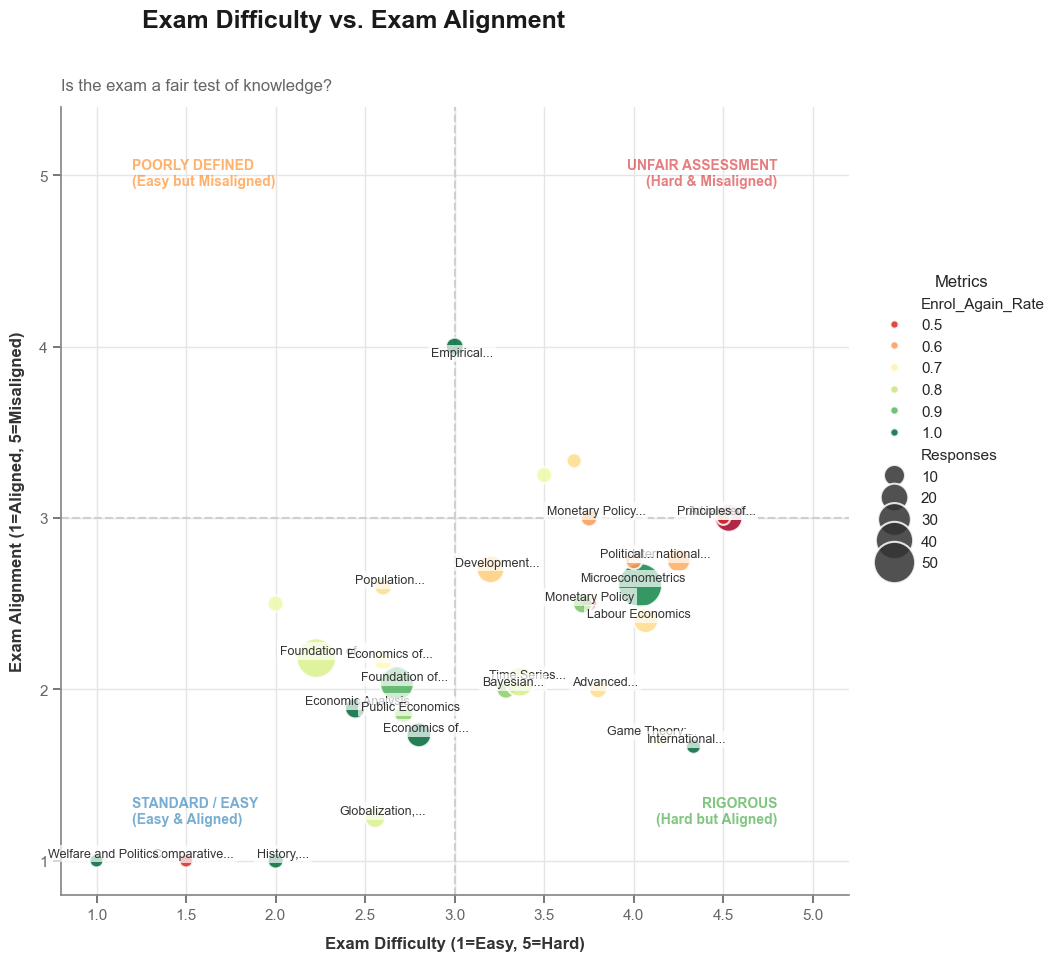

In [13]:
summary['dist_exam_diff_vs_exam_align'] = np.sqrt(
    (summary['Avg_Exam_Difficulty'] - 3)**2 + (summary['Avg_Exam_Alignment'] - 3)**2
)

fig, ax = plt.subplots(figsize=BUBBLE_CFG["figsize"])
apply_bubble_style(ax, xlim=(0.8, 5.2), ylim=(0.8, 5.4))

sns.scatterplot(
    data=summary,
    x='Avg_Exam_Difficulty',
    y='Avg_Exam_Alignment',
    size='Responses',
    hue='Enrol_Again_Rate',
    sizes=BUBBLE_CFG["sizes"],
    palette=BUBBLE_CFG["palette"],
    alpha=BUBBLE_CFG["alpha"],
    edgecolor=BUBBLE_CFG["edgecolor"],
    linewidth=BUBBLE_CFG["linewidth"],
    ax=ax,
    zorder=2
)

ax.set_xlabel('Exam Difficulty (1=Easy, 5=Hard)',
              fontsize=BUBBLE_CFG["label_fontsize"], fontweight=BUBBLE_CFG["label_weight"],
              labelpad=10, color=BUBBLE_CFG["label_color"])
ax.set_ylabel('Exam Alignment (1=Aligned, 5=Misaligned)',
              fontsize=BUBBLE_CFG["label_fontsize"], fontweight=BUBBLE_CFG["label_weight"],
              labelpad=10, color=BUBBLE_CFG["label_color"])

annotate_interesting_points(
    ax=ax,
    df=summary,
    x_col='Avg_Exam_Difficulty',
    y_col='Avg_Exam_Alignment',
    dist_col='dist_exam_diff_vs_exam_align'
)

ax.text(4.8, 5.1, "UNFAIR ASSESSMENT\n(Hard & Misaligned)",
        ha='right', va='top', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#d62728', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(4.8, 1.2, "RIGOROUS\n(Hard but Aligned)",
        ha='right', va='bottom', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#2ca02c', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(1.2, 1.2, "STANDARD / EASY\n(Easy & Aligned)",
        ha='left', va='bottom', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#1f77b4', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(1.2, 5.1, "POORLY DEFINED\n(Easy but Misaligned)",
        ha='left', va='top', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#ff7f0e', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])

fig.suptitle('Exam Difficulty vs. Exam Alignment',
             x=0.125, y=0.96, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')
ax.set_title('Is the exam a fair test of knowledge?',
             loc='left', fontsize=12, color='#666666', pad=12)

ax.legend(bbox_to_anchor=(1.02, 0.6), loc='center left', frameon=False, title="Metrics")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])

save_path = os.path.join(OUTPUT_DIR, 'fig_exam_difficulty_vs_exam_alignment_bubble.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
print(f"Saved plot to: {save_path}")
plt.show()

### Plot 4c: Course difficulty vs Exam difficulty scatter plot

Saved plot to: output/fig_course_vs_exam_difficulty_bubble.pdf


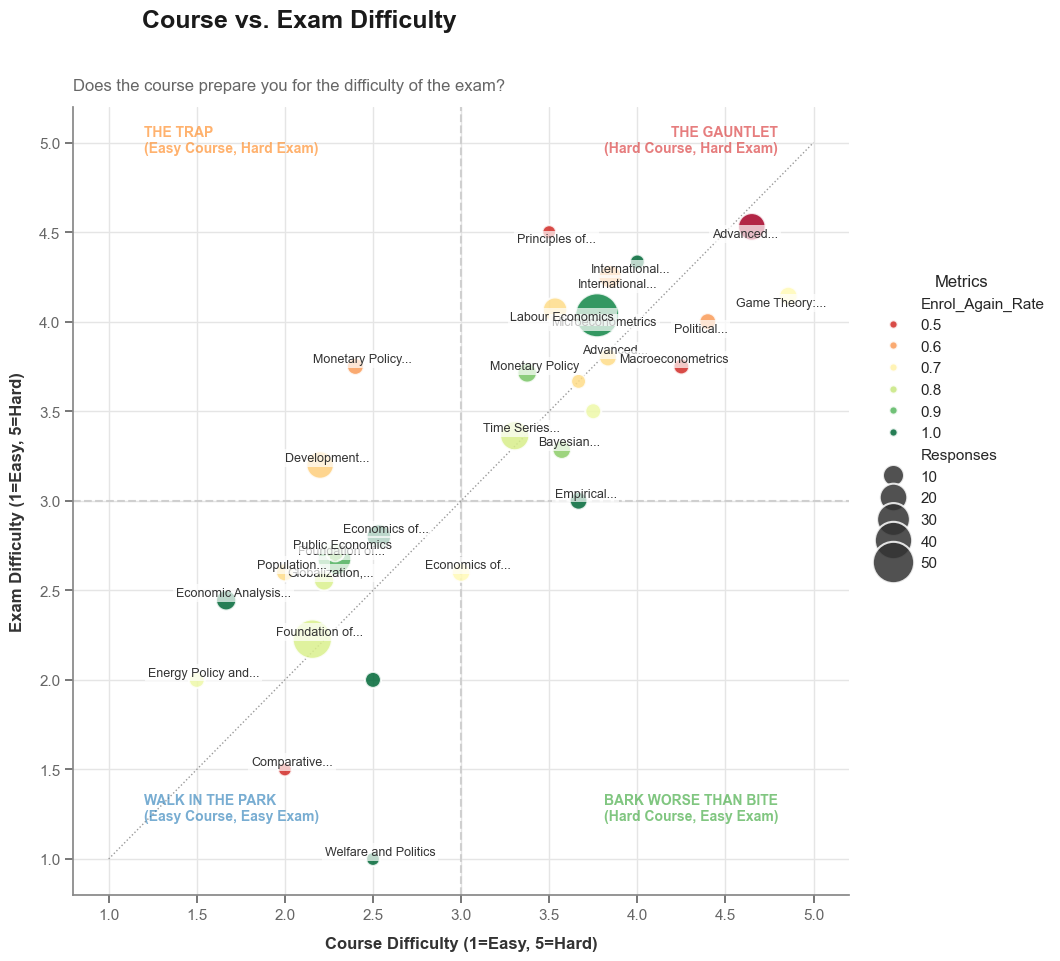

In [14]:
summary['dist_course_diff_vs_exam_diff'] = np.sqrt(
    (summary['Avg_Course_Difficulty'] - 3)**2 + (summary['Avg_Exam_Difficulty'] - 3)**2
)

fig, ax = plt.subplots(figsize=BUBBLE_CFG["figsize"])
apply_bubble_style(ax, xlim=(0.8, 5.2), ylim=(0.8, 5.2))

# Diagonal reference line (perfect match)
ax.plot([1, 5], [1, 5], ls=':', c='#999999', lw=1, zorder=1)

sns.scatterplot(
    data=summary,
    x='Avg_Course_Difficulty',
    y='Avg_Exam_Difficulty',
    size='Responses',
    hue='Enrol_Again_Rate',
    sizes=BUBBLE_CFG["sizes"],
    palette=BUBBLE_CFG["palette"],
    alpha=BUBBLE_CFG["alpha"],
    edgecolor=BUBBLE_CFG["edgecolor"],
    linewidth=BUBBLE_CFG["linewidth"],
    ax=ax,
    zorder=2
)

ax.set_xlabel('Course Difficulty (1=Easy, 5=Hard)',
              fontsize=BUBBLE_CFG["label_fontsize"], fontweight=BUBBLE_CFG["label_weight"],
              labelpad=10, color=BUBBLE_CFG["label_color"])
ax.set_ylabel('Exam Difficulty (1=Easy, 5=Hard)',
              fontsize=BUBBLE_CFG["label_fontsize"], fontweight=BUBBLE_CFG["label_weight"],
              labelpad=10, color=BUBBLE_CFG["label_color"])

annotate_interesting_points(
    ax=ax,
    df=summary,
    x_col='Avg_Course_Difficulty',
    y_col='Avg_Exam_Difficulty',
    dist_col='dist_course_diff_vs_exam_diff'
)

ax.text(4.8, 5.1, "THE GAUNTLET\n(Hard Course, Hard Exam)",
        ha='right', va='top', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#d62728', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(4.8, 1.2, "BARK WORSE THAN BITE\n(Hard Course, Easy Exam)",
        ha='right', va='bottom', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#2ca02c', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(1.2, 1.2, "WALK IN THE PARK\n(Easy Course, Easy Exam)",
        ha='left', va='bottom', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#1f77b4', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])
ax.text(1.2, 5.1, "THE TRAP\n(Easy Course, Hard Exam)",
        ha='left', va='top', fontsize=BUBBLE_CFG["quadrant_fontsize"],
        color='#ff7f0e', fontweight='bold', alpha=BUBBLE_CFG["quadrant_alpha"])

fig.suptitle('Course vs. Exam Difficulty',
             x=0.125, y=0.96, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')
ax.set_title('Does the course prepare you for the difficulty of the exam?',
             loc='left', fontsize=12, color='#666666', pad=12)

ax.legend(bbox_to_anchor=(1.02, 0.6), loc='center left', frameon=False, title="Metrics")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])

save_path = os.path.join(OUTPUT_DIR, 'fig_course_vs_exam_difficulty_bubble.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
print(f"Saved plot to: {save_path}")
plt.show()